In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("lab07.ipynb")

# Lab 7: Resampling and the Bootstrap

Welcome to Lab 7!

**Lab Queue**: You can find the Lab Queue at [lab.data8.org](https://lab.data8.org/). Whenever you feel stuck or need some further clarification, add yourself to the queue to get help from a GSI or academic intern! Please list your name, breakout room number, and purpose on your ticket!

**Deadline**: If you are not attending lab, you have to complete this lab and submit by Tuesday, 7/20 before 11:59 P.M. PST in order to receive lab credit. Otherwise, please attend the lab you are enrolled in, get checked off with your GSI or academic intern **AND** submit this assignment by the end of the lab section (with whatever progress you've made) to receive lab credit.

**Submission**: Once you're finished, scroll up to the top of the page, and run every cell in the notebook.  Select "Save and Checkpoint" in the File menu (please don’t hit Save As), then rerun the last cell of the notebook.  The result will contain a zip file that you can submit to Gradescope. If you are in lab, you can submit a ticket on lab.data8.org to ask a staff member to check you off. 

***

The British Royal Air Force wanted to know how many warplanes the Germans had (some number `N`, which is a *parameter*), and they needed to estimate that quantity knowing only a random sample of the planes' serial numbers (from 1 to `N`). We know that the German's warplanes are labeled consecutively from 1 to `N`, so `N` would be the total number of warplanes they have. 

We normally investigate the random variation among our estimates by simulating a sampling procedure from the population many times and computing estimates from each sample that we generate.  In real life, if the RAF had known what the population looked like, they would have known `N` and would not have had any reason to think about random sampling. However, they didn't know what the population looked like, so they couldn't have run the simulations that we normally do.  

Simulating a sampling procedure many times was a useful exercise in *understanding random variation* for an estimate, but it's not as useful as a tool for practical data analysis.

Let's flip that sampling idea on its head to make it practical. Given *just* a random sample of serial numbers, we'll estimate `N`, and then we'll use simulation to find out how accurate our estimate probably is, without ever looking at the whole population.  This is an example of *statistical inference*.

First, set up the notebook by running the cell below.

In [2]:
# Run this cell to set up the notebook, but please don't change it.

# These lines import the Numpy and Datascience modules.
import numpy as np
from datascience import *

# These lines do some fancy plotting magic.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)

## 1. Preliminaries
We (the RAF in World War II) want to know the number of warplanes fielded by the Germans.  That number is `N`.  The warplanes have serial numbers from 1 to `N`, so `N` is also equal to the largest serial number on any of the warplanes.

We only see a small number of serial numbers (assumed to be a random sample with replacement from among all the serial numbers), so we have to use estimation.

#### Question 1.1
Is `N` a population parameter or a statistic?  If we use our random sample to compute a number that is an estimate of `N`, is that a population parameter or a statistic?

<!--
BEGIN QUESTION
name: q1_1
-->

_N is a population parameter because it is a fixed quantity associated with the original population. If we use our random sample to compute a number that is an estimate of N, it is a statistic because it is an not exact and is an approximation from our random sample._

To make the situation realistic, we're going to hide the true number of warplanes from you.  You'll have access only to this random sample:

In [3]:
observations = Table.read_table("serial_numbers.csv")
num_observations = observations.num_rows
observations

serial number
47
42
57
79
26
23
36
64
83
135


#### Question 1.2
The average of the sample is about half of `N`. So one way to estimate `N` is to take twice the mean of the serial numbers we see. Write a function that computes that statistic.  It should take as its argument an array of serial numbers and return twice their mean.  Call the function `mean_based_estimator`.  

After that, use it to compute an estimate of `N` called `mean_based_estimate`.

<!--
BEGIN QUESTION
name: q1_2
-->

In [7]:
def mean_based_estimator(nums):
    return np.mean(nums) * 2

mean_based_estimate = mean_based_estimator(observations.column(0))
mean_based_estimate

122.47058823529412

In [8]:
grader.check("q1_2")

q1_2 results: All test cases passed!

#### Question 1.3
We can also estimate `N` by using the biggest serial number in the sample.  Compute this value and give it the name `max_estimate`.

<!--
BEGIN QUESTION
name: q1_3
-->

In [15]:
max_estimate = max(observations.column(0))
max_estimate

135

In [16]:
grader.check("q1_3")

q1_3 results: All test cases passed!

#### Question 1.4
Let's take a look at the values of `max_estimate` and `mean_based_estimate` that we got for our dataset. Which of these values is closer to the true population maximum `N`? Based off of our estimators, can we give a lower bound for what `N` must be? In other words, is there a value that `N` must be greater than or equal to?

<!--
BEGIN QUESTION
name: q1_4
-->

_N is at least 135._

We can't just confidently proclaim that `max_estimate` or `mean_based_estimate` is equal to `N`.  What if we're really far off?  So we want to get a sense of the accuracy of our estimates.

## 2. Resampling
To do this, we'll use resampling.  That is, we won't exactly simulate the observations the RAF would have really seen.  Rather we sample from our current sample, or "resample."

Why does that make any sense?

When we try to find the value of a population parameter, we ideally would like to use the whole population. However, we often only have access to one sample and we must use that to estimate the parameter instead.

Here, we would like to use the population of serial numbers to draw more samples and run a simulation about estimates of `N`.  But we still only have our sample.  So, we **use our sample in place of the population** to run the simulation. We resample from our original sample with replacement as many times as there are elements in the original sample. This resampling technique is called *bootstrapping*. 

Note that in order for bootstrapping to work well, you must start with a large, random sample. Then the Law of Averages says that with high probability, your sample is representative of the population.

#### Question 2.1
Write a function called `simulate_resample`. The function should take no arguments and generate a resample from the observed serial numbers in `observations`. The resample should be a table with the same column names as `observations`.

<!--
BEGIN QUESTION
name: q2_1
-->

In [23]:
def simulate_resample():
    return observations.sample(with_replacement=True)

In [24]:
grader.check("q2_1")

q2_1 results: All test cases passed!

We'll use many resamples at once to see what estimates typically look like.  However, we don't often pay attention to single resamples, so it's easy to misunderstand them.  Let's first answer some questions about our resample.

#### Question 2.2
Which of the following statements are true?

1. The resample can contain serial numbers that are not in the original sample.
2. The original sample can contain serial numbers that are not in the resample.
3. The resample has either zero, one, or more than one copy of each serial number.
4. The original sample has exactly one copy of each serial number.

Assign `true_statements` to an array of the number(s) corresponding to correct statements.

<!--
BEGIN QUESTION
name: q2_2
-->

In [27]:
true_statements = make_array(2, 3)

In [28]:
grader.check("q2_2")

q2_2 results: All test cases passed!

Now let's write a function to do many resamples at once.

Since resampling from a sample looks just like sampling from a population, the code should look almost the same.  That means we can write a function that simulates the process of either sampling from a population or resampling from a sample.  If we pass in population as its argument, it will do the former; if we pass in a sample, it will do the latter.

#### Question 2.3
Write a function called `sample_estimates`.  It should take 4 arguments:
1. `serial_num_tbl`: A table from which the data should be sampled.  The table will have one column named `serial number`.
2. `sample_size`: The size of each sample from that table, an integer.  
    - For example, to bootstrap, we would pass in the number of rows in the table.
3. `statistic`: A *function* that takes in an array of serial numbers as its argument and computes a statistic from the array (i.e. returns a calculated number). 
4. `num_replications`: The number of simulations to perform.

The function should simulate many samples **with replacement** from the given table.  (The number of times it does this is the 4th argument.)  

For each of those samples, it should compute the statistic on that sample. Then it should **return an array** containing each of those statistics.  The code below provides an example use of your function and describes how you can verify that you've written it correctly.

<!--
BEGIN QUESTION
name: q2_3
-->

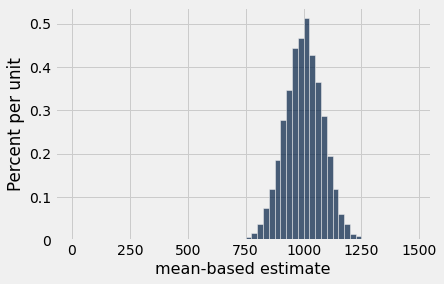

In [30]:
def sample_estimates(serial_num_tbl, sample_size, statistic, num_replications):
    result = make_array()
    for i in np.arange(num_replications):
        one_stat = statistic(serial_num_tbl.sample(sample_size, with_replacement=True).column(0))
        result = np.append(result, one_stat)
    return result

# Don't change the code below this comment!
# This should generate an empirical histogram of twice-mean-based estimates
# of N from samples of size 50 if N is 1000.  This should be a bell-shaped
# curve centered at 1000 with most of its mass in [800, 1200].  To verify your
# answer, make sure that's what you see!
population = Table().with_column("serial number", np.arange(1, 1000+1))
example_estimates = sample_estimates(
    population,
    50,
    mean_based_estimator,
    10000)
Table().with_column("mean-based estimate", example_estimates).hist(bins=np.arange(0, 1500, 25))

In [31]:
grader.check("q2_3")

q2_3 results: All test cases passed!

Now we can go back to the sample we actually observed (the table `observations`) and estimate how much our mean-based estimate of `N` would have varied from sample to sample.

#### Question 2.4
Using the bootstrap and the sample `observations`, simulate the approximate distribution of *mean-based estimates* of `N`.  Use 10,000 replications and save the estimates in an array called `bootstrap_mean_based_estimates`.  

We have provided code that plots a histogram, allowing you to visualize the simulated estimates.

<!--
BEGIN QUESTION
name: q2_4
-->

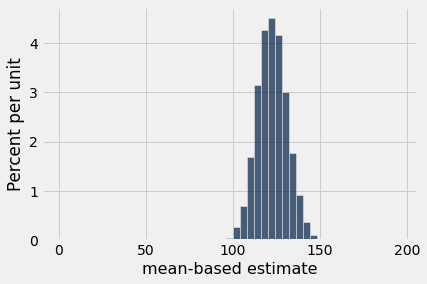

In [40]:
bootstrap_mean_based_estimates = sample_estimates(observations, 50, mean_based_estimator, 10000)

# Don't change the code below! This plots bootstrap_mean_based_estimates.
Table().with_column("mean-based estimate", bootstrap_mean_based_estimates).hist(bins=np.arange(0, 200, 4)) 

In [41]:
grader.check("q2_4")

q2_4 results: All test cases passed!

#### Question 2.5
Using the bootstrap and the sample `observations`, simulate the approximate distribution of *max estimates* of `N`.  Use 10,000 replications and save the estimates in an array called `bootstrap_max_estimates`.

We have provided code that plots a histogram, allowing you to visualize the simulated estimates.

<!--
BEGIN QUESTION
name: q2_5
-->

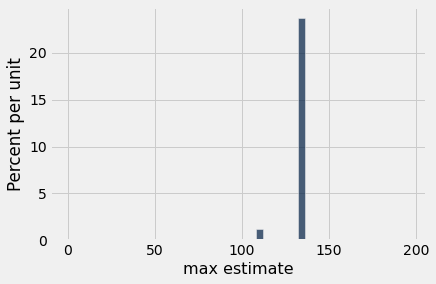

In [43]:
bootstrap_max_estimates = sample_estimates(observations, 50, max, 10000)

# Don't change the code below! This plots bootstrap_max_estimates.
Table().with_column("max estimate", bootstrap_max_estimates).hist(bins=np.arange(0, 200, 4)) 

In [44]:
grader.check("q2_5")

q2_5 results: All test cases passed!

#### Question 2.6
`N` was actually 150! Compare the histograms of estimates you generated in 2.4 and 2.5 and answer the following questions:

1. How does the distribution of values for the mean-based estimates differ from the max estimates? Do both distributions contain the true max value?
2. Which estimator is more dependent on the original random sample? Why so?

<!--
BEGIN QUESTION
name: q2_6
-->

_The distribution of values for the mean-based estimates is bell-shaped and centered around 125 whereas the distribution of max estimates is a lot sparser and the range is narraw. Max estimate is more dependent on the original random sample because max is determined by one value and if it's changed the entire result changes vastly however with mean estimate only a little is effected._

## 3. Computing intervals

#### Question 3.1
Compute an interval that covers the middle 95% of the mean-based bootstrap estimates.  Assign your values to `left_end_1` and `right_end_1`. 

*Hint:* Use the `percentile` function! Read up on its documentation [here](http://data8.org/sp19/python-reference.html).

Verify that your interval looks like it covers 95% of the area in the histogram. The red dot on the histogram is the value of the parameter (150).

<!--
BEGIN QUESTION
name: q3_1
-->

Middle 95% of bootstrap estimates: [106.120000, 139.400000]


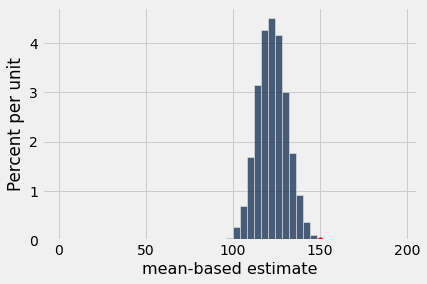

In [54]:
left_end_1 = percentile(2.5, bootstrap_mean_based_estimates)
right_end_1 = percentile(97.5, bootstrap_mean_based_estimates)
print("Middle 95% of bootstrap estimates: [{:f}, {:f}]".format(left_end_1, right_end_1))

# Don't change the code below! It draws your interval and N on the histogram of mean-based estimates.
Table().with_column("mean-based estimate", bootstrap_mean_based_estimates).hist(bins=np.arange(0, 200, 4)) 
plt.plot(make_array(left_end_1, right_end_1), make_array(0, 0), color='yellow', lw=3, zorder=1)
plt.scatter(150, 0, color='red', s=30, zorder=2);

In [55]:
grader.check("q3_1")

q3_1 results: All test cases passed!

#### Question 3.2
Write code that simulates the sampling and bootstrapping process again, as follows:

1. Generate a new set of random observations the RAF might have seen by sampling from the `population` table we have created for you below. Use the sample size `num_observations`.
2. Compute an estimate of `N` from these new observations, using `mean_based_estimator`.
3. Using only the new observations, compute 10,000 bootstrap estimates of `N`.
4. Plot these bootstrap estimates and compute an interval covering the middle 95%.

<!--
BEGIN QUESTION
name: q3_2
-->

New mean-based estimate: 159.647059
Middle 95% of bootstrap estimates: [137.520000, 181.640000]


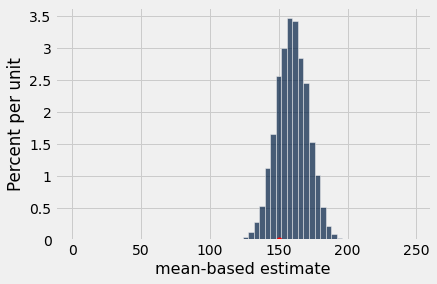

In [58]:
population = Table().with_column("serial number", np.arange(1, 150+1))

new_observations = population.sample(num_observations, with_replacement=False)
new_mean_based_estimate = mean_based_estimator(new_observations.column(0))
new_bootstrap_estimates = sample_estimates(new_observations, 50, mean_based_estimator, 10000)
Table().with_column("mean-based estimate", new_bootstrap_estimates).hist(bins=np.arange(0, 252, 4))
new_left_end = percentile(2.5, new_bootstrap_estimates)
new_right_end = percentile(97.5, new_bootstrap_estimates)

# Don't change code below this line!
print("New mean-based estimate: {:f}".format(new_mean_based_estimate))
print("Middle 95% of bootstrap estimates: [{:f}, {:f}]".format(new_left_end, new_right_end))

plt.plot(make_array(new_left_end, new_right_end), make_array(0, 0), color='yellow', lw=3, zorder=1)
plt.scatter(150, 0, color='red', s=30, zorder=2);

#### Question 3.3
Does the interval covering the middle 95% of the new bootstrap estimates include `N`?  If you ran that cell 100 times and generated 100 intervals, how many of those intervals would you expect to include `N`?

<!--
BEGIN QUESTION
name: q3_3
-->

_Yes the interval covering the middle 95% includes N. We would expect 95 of 100 intervals to include N._

## 4. Submission

Congratulations, you're done with Lab 7!  Be sure to 
- **Run all the tests** (the next cell has a shortcut for that). 
- **Save and Checkpoint** from the `File` menu.
- **Run the cell at the bottom to download a .zip file and submit to Gradescope. **.
- If you're in lab, ask one of the staff members to check you off.

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [59]:
grader.check_all()

q1_2 results: All test cases passed!

q1_3 results: All test cases passed!

q2_1 results: All test cases passed!

q2_2 results: All test cases passed!

q2_3 results: All test cases passed!

q2_4 results: All test cases passed!

q2_5 results: All test cases passed!

q3_1 results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [60]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False)